# Assemble Model using DenseNet, EfficientNet, ResNet50, XGBoost, Light GBM, and CatBoost

## Here's datasets you will need
- train-image.hdf5
- train-metadata.csv
- augmented_data.hdf5
- augmented_metadata.csv
- isic_image.hdf5
- isic_metadata.csv
- test-image.hdf5
- test-metadata.csv
## Here's the models/paths you need to run without training the CNN model
- DenseNet121_checkpoints/DenseNet121_epoch_20.pth
- EfficientNet-B3_checkpoints/EfficientNet-B3_epoch_20.pth
- ResNet50_checkpoints/ResNet50_epoch_20.pth

## Dependencies

In [6]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from PIL import Image

class HDF5Dataset(Dataset):
    __slots__ = ['images', 'labels', 'augment', 'transform']

    def __init__(self, images, labels, augment=False, transform=None):
        self.images = images
        self.labels = labels
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert from numpy to PIL only if needed
        if isinstance(image, np.ndarray):
            if image.dtype != np.uint8:
                image = (image * 255).clip(0, 255).astype(np.uint8)  # ensure valid range
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # Directly return float tensor
        return image, torch.tensor(label, dtype=torch.float32)

In [7]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
# from dataset import HDF5Dataset
from sklearn.metrics import roc_auc_score, roc_curve
from isic_metric import score

In [8]:
# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading

In [9]:
images = []
labels = []
metadata = []
malignant_count = 0
benign_count = 0

### First, load all data from original database

In [10]:
# load isic_ids from 3 csv files
test_ids = pd.read_csv("test_id.csv")["isic_id"].tolist()
train_ids = pd.read_csv("train_id.csv")["isic_id"].tolist()
val_ids = pd.read_csv("val_id.csv")["isic_id"].tolist()
# only load 600 for training, 150 for validation, 250 for testing
train_ids = train_ids[:600]
val_ids = val_ids[:150]
test_ids = test_ids[:250]

## read in each section

In [11]:
original_train_hdf5_path = 'train-image.hdf5'
original_train_metadata_path = 'train-metadata.csv'
original_train_metadata = pd.read_csv(original_train_metadata_path,low_memory=False)   
original_train_metadata.set_index('isic_id', inplace=True)
original_train_hdf5 = h5py.File(original_train_hdf5_path, 'r')

In [12]:
X_train = []
y_train = []
metadata_train = []
X_val = []
y_val = []
metadata_val = []
X_test = []
y_test = []
metadata_test = []

In [13]:
def load_images_and_labels(hdf5_file, metadata_df, id_list):
    images = []
    labels = []
    meta_records = []

    for isic_id in tqdm(id_list):
        # get label and metadata
        record = metadata_df.loc[isic_id].copy()
        label = int(record["target"])
        if label == 0 and len(labels) >= len(id_list) * 0.5: # limit benign samples to 50%
            continue
            
        # load and decode image
        image = hdf5_file[isic_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        image = image / 255.0  # normalize
        
        record["isic_id"] = isic_id
        
        images.append(image)
        labels.append(label)
        meta_records.append(record)

    return images, labels, meta_records

In [14]:
X_train, y_train, metadata_train = load_images_and_labels(original_train_hdf5, original_train_metadata, train_ids)
X_val, y_val, metadata_val = load_images_and_labels(original_train_hdf5, original_train_metadata, val_ids)
X_test, y_test, metadata_test = load_images_and_labels(original_train_hdf5, original_train_metadata, test_ids)


100%|██████████| 250/250 [00:00<00:00, 2030.75it/s]


In [15]:
malignant_count = sum(y == 1 for y in y_train)
benign_count = sum(y == 0 for y in y_train)
print(f"Malignant count: {malignant_count}")
print(f"Benign count: {benign_count}")

Malignant count: 1
Benign count: 299


In [16]:
# print first test metadata
print(metadata_test[0]['isic_id'])

ISIC_0015845


In [17]:
print(f'Training data: {len(X_train)}')
print(f'Validation data: {len(X_val)}')
print(f'Test data: {len(X_test)}')
print(f'Metadata Training data: {len(metadata_train)}')
print(f'Metadata Validation data: {len(metadata_val)}')
print(f'Metadata Test data: {len(metadata_test)}')
print(f'Malignant count: {malignant_count}')
print(f'Benign count: {benign_count}')

Training data: 300
Validation data: 75
Test data: 125
Metadata Training data: 300
Metadata Validation data: 75
Metadata Test data: 125
Malignant count: 1
Benign count: 299


## Load CNN models

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### DenseNet

In [19]:
import torch.optim as optim
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn
from tqdm import tqdm
from isic_metric import score
from sklearn.metrics import roc_auc_score, roc_curve

class Trainer:
    def __init__(self, device, train_dataset, val_dataset, nn_name, weights, transform, model, num_pos, num_neg, lr=1e-5, num_epochs=20):
        self.device = device
        self.weights = weights
        self.transform = transform
        self.model = model
        if nn_name == "EfficientNet-B3": # EfficientNet
            print("EfficientNet Configuration")
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features, 1)
        elif nn_name == "DenseNet121": # DenseNet
            in_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(in_features, 1)
        elif nn_name == "ResNet50": # ResNet
            model.fc = nn.Linear(model.fc.in_features, 1)
        self.model = self.model.to(self.device)
        # handle imbalance dataset
        # labels_list = [label for _, label in train_dataset]
        # labels_tensor = torch.tensor(labels_list)
        
        # num_neg = (labels_tensor == 0).sum().item()
        # num_pos = (labels_tensor == 1).sum().item()
        
        # compute pos_weight
        pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float).to(self.device)
        print(f'Using pos_weight criterion: {pos_weight}')
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        # self.criterion = nn.BCEWithLogitsLoss()
        # self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.optimizer = optim.SGD(
        self.model.parameters(),
            lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True
        )
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.num_epochs = num_epochs
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.partial_aucs = []
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
        self.val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
        self.nn_name = nn_name
        
        # make directory for saving checkpoints
        if not os.path.exists(f"{self.nn_name}_checkpoints"):
            os.makedirs(f"{self.nn_name}_checkpoints")
    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            epoch_loss = 0

            for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.num_epochs}"):
                inputs = inputs.to(self.device)
                labels = labels.float().unsqueeze(1).to(self.device)  # [B, 1]

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            self.train_losses.append(epoch_loss / len(self.train_loader))

            # === Validation ===
            self.model.eval()
            val_loss = 0
            preds, targets = [], []

            with torch.no_grad():
                for inputs, labels in tqdm(self.val_loader, desc=f"Validation"):
                    inputs = inputs.to(self.device)
                    labels = labels.float().unsqueeze(1).to(self.device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()

                    preds.extend(torch.sigmoid(outputs).cpu().numpy())
                    targets.extend(labels.cpu().numpy())

            self.val_losses.append(val_loss / len(self.val_loader))
            val_auc = roc_auc_score(targets, preds)
            
            # Threshold predictions at 0.5
            pred_labels = (np.array(preds) >= 0.5).astype(int)
            true_labels = np.array(targets).astype(int)

            
            # Partial AUC Computation 
            true_labels = np.array(targets).astype(int).flatten()
            preds = np.array(preds).flatten()
            df_sol = pd.DataFrame({
                "image_id": list(range(len(true_labels))),
                "target": true_labels
            })
            
            df_sub = pd.DataFrame({
                "image_id": list(range(len(preds))),
                "target": preds  # prediction probabilities
            })
            
            # Compute pAUC from official metric
            pauc = score(df_sol, df_sub, row_id_column_name="image_id", min_tpr=0.80)
            self.partial_aucs.append(pauc)
            
            val_acc = accuracy_score(true_labels, pred_labels)
            val_precision = precision_score(true_labels, pred_labels)
            val_recall = recall_score(true_labels, pred_labels)
            val_f1 = f1_score(true_labels, pred_labels)

            print(f"Epoch {epoch+1}: Acc = {val_acc:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 = {val_f1:.4f}, pAUC = {pauc:.4f}")    
            self.val_accuracies.append(val_acc)
            self.val_precisions.append(val_precision)
            self.val_recalls.append(val_recall)
            self.val_f1s.append(val_f1)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'train_loss': self.train_losses[-1],
                'val_loss': self.val_losses[-1],
                'val_auc': val_auc
            }, f"{self.nn_name}_checkpoints/{self.nn_name}_epoch_{epoch+1}.pth")
            
            self.scheduler.step()

            
        # plot loss curves
        plt.plot(self.train_losses, label='Train')
        plt.plot(self.val_losses, label='Validation')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.nn_name} Training Loss")
        plt.legend()
        plt.savefig(f"{self.nn_name}_loss_curve.png")
        # plot pAUC
        epochs = list(range(1, self.num_epochs + 1))

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.partial_aucs, marker='o', label="Partial AUC @ TPR>0.8")
        plt.title(f"{self.nn_name} Partial AUC over Epochs (FPR ≤ 0.2)")
        plt.xlabel("Epoch")
        plt.ylabel("Partial AUC (scaled)")
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{self.nn_name}_partial_auc_curve.png")

In [20]:
from torchvision.models import densenet121, DenseNet121_Weights
# from ModelTrainer import Trainer
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_transform = densenet_weights.transforms()
densenet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=densenet_transform)
densenet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=densenet_transform)
densenet_model = densenet121(weights=densenet_weights)
lr = 1e-5
num_epochs = 20
dense_net_trainer = Trainer(device, densenet_train_dataset, densenet_val_dataset, "DenseNet121", densenet_weights, densenet_transform, densenet_model, malignant_count, benign_count, lr, num_epochs)

Using pos_weight criterion: tensor([299.], device='cuda:0')


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch 1: Acc = 0.3467, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0703


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 2: Acc = 0.5067, Precision = 0.0263, Recall = 1.0000, F1 = 0.0513, pAUC = 0.1108


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


Epoch 3: Acc = 0.5200, Precision = 0.0270, Recall = 1.0000, F1 = 0.0526, pAUC = 0.1514


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch 4: Acc = 0.5600, Precision = 0.0294, Recall = 1.0000, F1 = 0.0571, pAUC = 0.1676


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


Epoch 5: Acc = 0.5733, Precision = 0.0303, Recall = 1.0000, F1 = 0.0588, pAUC = 0.1595


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


Epoch 6: Acc = 0.6267, Precision = 0.0345, Recall = 1.0000, F1 = 0.0667, pAUC = 0.1757


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 7: Acc = 0.6800, Precision = 0.0400, Recall = 1.0000, F1 = 0.0769, pAUC = 0.1784


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Epoch 8: Acc = 0.7200, Precision = 0.0455, Recall = 1.0000, F1 = 0.0870, pAUC = 0.1784


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


Epoch 9: Acc = 0.7600, Precision = 0.0526, Recall = 1.0000, F1 = 0.1000, pAUC = 0.1838


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Epoch 10: Acc = 0.7733, Precision = 0.0556, Recall = 1.0000, F1 = 0.1053, pAUC = 0.1784


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Epoch 11: Acc = 0.7733, Precision = 0.0556, Recall = 1.0000, F1 = 0.1053, pAUC = 0.1838


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Epoch 12: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1865


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Epoch 13: Acc = 0.8133, Precision = 0.0667, Recall = 1.0000, F1 = 0.1250, pAUC = 0.1919


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Epoch 14: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1919


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch 15: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1919


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Epoch 16: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1946


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Epoch 17: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1946


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Epoch 18: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1973


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s]


Epoch 19: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1946


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Epoch 20: Acc = 0.7733, Precision = 0.0556, Recall = 1.0000, F1 = 0.1053, pAUC = 0.1946


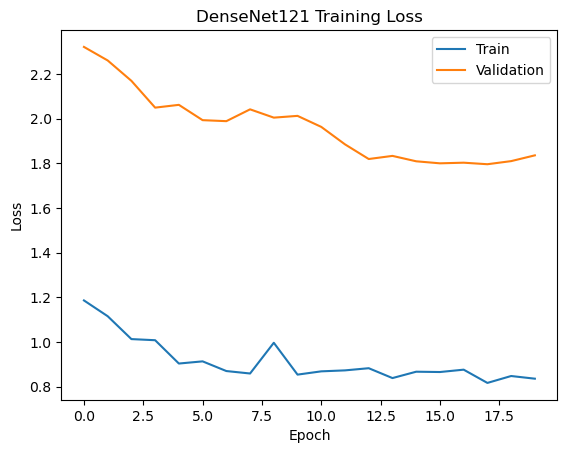

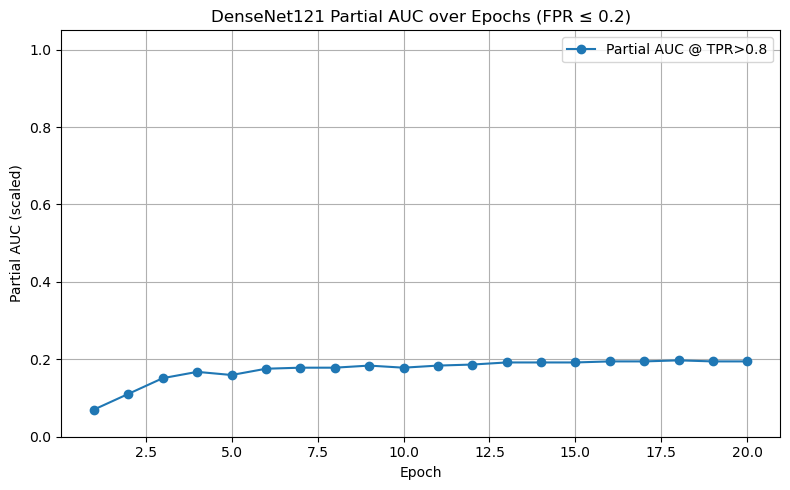

In [21]:
dense_net_trainer.train()

### Load model if already trained and calculate pAUC

In [22]:
# densenet_model_path = "DenseNet121_checkpoints/DenseNet121_epoch_20.pth"
# densenet_checkpoint = torch.load(densenet_model_path, weights_only=False, map_location=device)
# dense_net_trainer.model.load_state_dict(densenet_checkpoint['model_state_dict'])

### Calculate test pAUC 

In [23]:
from calc_pauc import pAUC
dense_net_trainer.model.eval()
calc_pAUC = pAUC(device, dense_net_trainer.model, dense_net_trainer.transform, X_test, y_test,  metadata_test)
pAUC_val = calc_pAUC.compute_pAUC()
print(f"pAUC for densenet: {pAUC_val}")

100%|██████████| 125/125 [00:01<00:00, 64.05it/s]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## EfficientNet

In [24]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import gc
# efficientnet_weights = EfficientNet_B3_Weights.DEFAULT
efficientnet_weights = EfficientNet_B0_Weights.DEFAULT
efficientnet_transform = efficientnet_weights.transforms()
efficientnet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=efficientnet_transform)
efficientnet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=efficientnet_transform)
# efficientnet_model = efficientnet_b3(weights=efficientnet_weights)
efficientnet_model = efficientnet_b0(weights=efficientnet_weights)
lr = 3e-5
num_epochs = 20
efficientnet_trainer = Trainer(device, efficientnet_train_dataset, efficientnet_val_dataset, "EfficientNet-B3", efficientnet_weights, efficientnet_transform, efficientnet_model, malignant_count, benign_count, lr, num_epochs)
del efficientnet_train_dataset
del efficientnet_val_dataset
gc.collect()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/mperform/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


EfficientNet Configuration
Using pos_weight criterion: tensor([299.], device='cuda:0')


909

Validation: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


Epoch 1: Acc = 0.5200, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0351


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


Epoch 2: Acc = 0.5467, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0297


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]


Epoch 3: Acc = 0.6933, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1027


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 4: Acc = 0.7467, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0351


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


Epoch 5: Acc = 0.6800, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0081


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]


Epoch 6: Acc = 0.7600, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0324


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


Epoch 7: Acc = 0.7600, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0784


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


Epoch 8: Acc = 0.7733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1568


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


Epoch 9: Acc = 0.7600, Precision = 0.0526, Recall = 1.0000, F1 = 0.1000, pAUC = 0.1676


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


Epoch 10: Acc = 0.7600, Precision = 0.0526, Recall = 1.0000, F1 = 0.1000, pAUC = 0.1676


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s]


Epoch 11: Acc = 0.7733, Precision = 0.0556, Recall = 1.0000, F1 = 0.1053, pAUC = 0.1595


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 12: Acc = 0.7867, Precision = 0.0588, Recall = 1.0000, F1 = 0.1111, pAUC = 0.1568


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


Epoch 13: Acc = 0.7600, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1514


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 14: Acc = 0.7733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1432


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


Epoch 15: Acc = 0.7733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1486


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 16: Acc = 0.7600, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1486


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 17: Acc = 0.7333, Precision = 0.0476, Recall = 1.0000, F1 = 0.0909, pAUC = 0.1541


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


Epoch 18: Acc = 0.7467, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1459


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


Epoch 19: Acc = 0.7333, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1459


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


Epoch 20: Acc = 0.7333, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1432


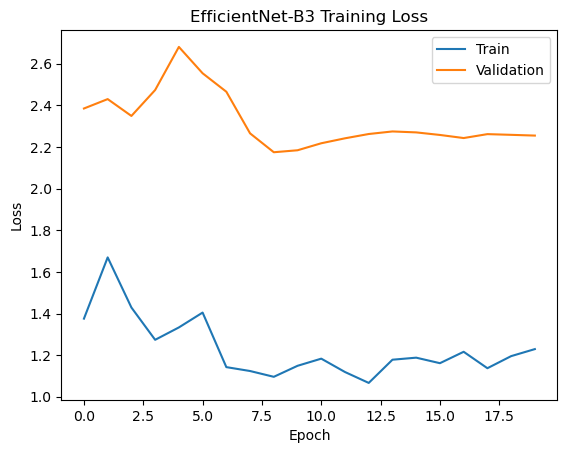

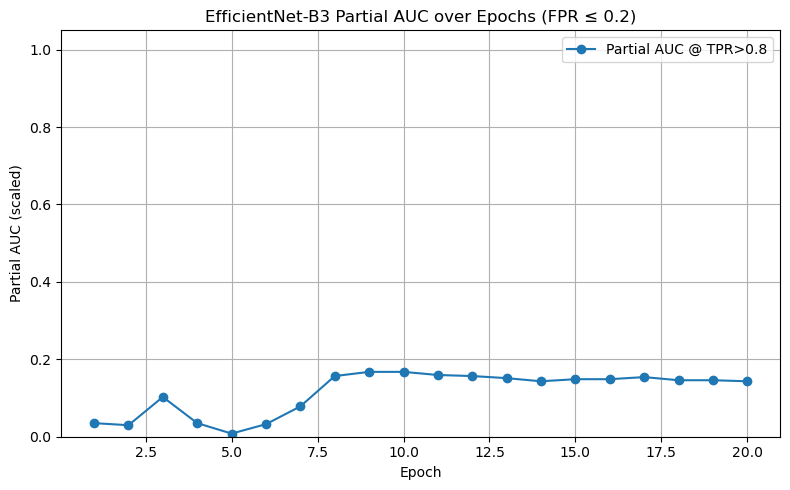

In [25]:
efficientnet_trainer.train()

### Load EfficientNet Model if already trained and compute pAUC

In [ ]:
# efficientnet_model_path = "EfficientNet-B3_checkpoints/EfficientNet-B3_epoch_20.pth"
# efficientnet_checkpoint = torch.load(efficientnet_model_path, weights_only=False, map_location=device)
# efficientnet_model.load_state_dict(efficientnet_checkpoint['model_state_dict'])

<All keys matched successfully>

### pAUC calculation

In [ ]:
efficientnet_model.eval()
from calc_pauc import pAUC
calc_pAUC = pAUC(device, efficientnet_trainer.model, efficientnet_trainer.transform, X_test, y_test,  metadata_test)
pAUC_val = calc_pAUC.compute_pAUC()
print(f"pAUC for efficientnet: {pAUC_val}")

## ResNet50

In [34]:
# from torchvision.models import resnet50, ResNet50_Weightsabs
from torchvision.models import resnet18, ResNet18_Weights
resnet_weights = ResNet18_Weights.DEFAULT
resnet_transform = resnet_weights.transforms()
# resnet_weights = ResNet50_Weights.DEFAULTabs
# resnet_transform = resnet_weights.transforms()

resnet_train_dataset = HDF5Dataset(X_train, y_train, transform=resnet_transform)
resnet_val_dataset = HDF5Dataset(X_val, y_val, transform=resnet_transform)
resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)

lr = 5e-5
num_epochs = 20
resnet_trainer = Trainer(device, resnet_train_dataset, resnet_val_dataset, "ResNet50", resnet_weights, resnet_transform, resnet_model, malignant_count, benign_count, lr, num_epochs)

/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using pos_weight criterion: tensor([299.], device='cuda:0')


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


Epoch 1: Acc = 0.9600, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0838


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s]


Epoch 2: Acc = 0.9067, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0973


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


Epoch 3: Acc = 0.8667, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1081


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


Epoch 4: Acc = 0.9733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.1081


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0838


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0541


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0270


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0162


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0432


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Epoch 10: Acc = 0.9733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0405


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


Epoch 11: Acc = 0.9733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0486


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Epoch 12: Acc = 0.9733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0514


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Epoch 13: Acc = 0.9733, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0514


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0459


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0459


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0486


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0459


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0486


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0486


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20: Acc = 0.9867, Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, pAUC = 0.0486


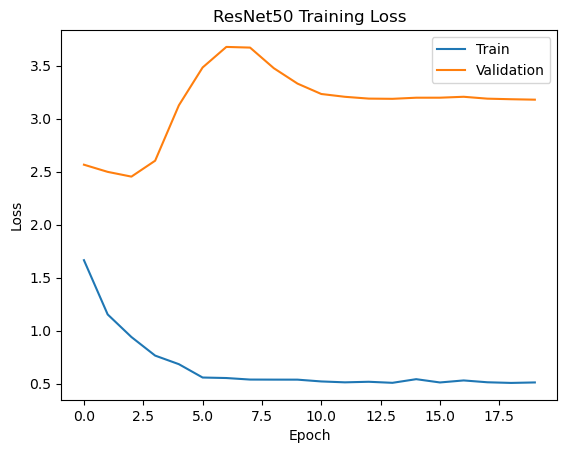

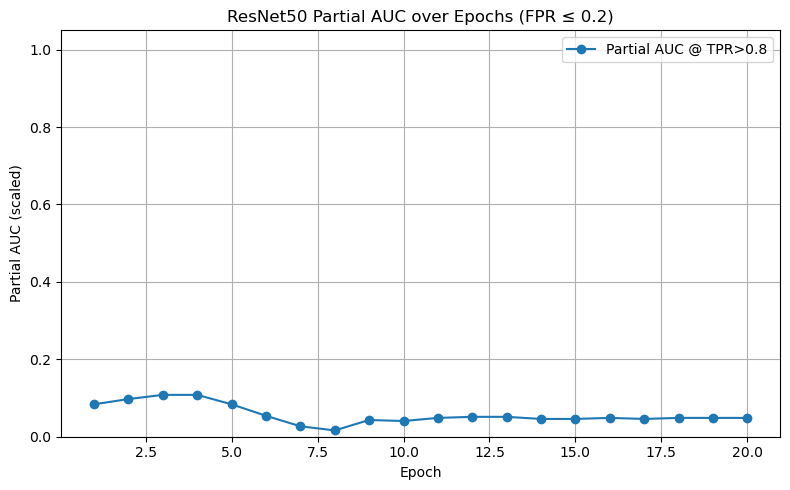

In [35]:
resnet_trainer.train()

### Load ResNet50 if already trained and calculate pAUC

In [ ]:
# resnet_model_path = "ResNet50_checkpoints/ResNet50_epoch_20.pth"
# resnet_checkpoint = torch.load(resnet_model_path, weights_only=False, map_location=device)
# resnet_trainer.model.load_state_dict(resnet_checkpoint['model_state_dict'])

### pAUC Calculation

In [ ]:
resnet_model.eval()
calc_pAUC = pAUC(device, resnet_trainer.model, resnet_trainer.transform, X_test, y_test,  metadata_test)
pAUC_val = calc_pAUC.compute_pAUC()
print(f"pAUC for resnet: {pAUC_val}")

## Output predictions for train/val/test for all CNN models

#### Convert CNNs's output predictions

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn.functional as F
from PIL import Image

class TorchCNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device='cpu', transform=None, threshold=0.5):
        self.model = model.eval().to(device)
        self.device = device
        self.transform = transform
        self.threshold = threshold

    def _prepare_image(self, img):
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)
        return self.transform(img).unsqueeze(0).to(self.device)

    def predict_proba(self, X):
        self.model.eval()
        probs = []
    
        with torch.no_grad():
            for img in tqdm(X, desc="Predicting with CNN"):
                img_tensor = self._prepare_image(img)
                logits = self.model(img_tensor)
                prob = torch.sigmoid(logits).cpu().item()
                probs.append(prob)
                # probs.append([1 - prob, prob])
    
        return probs

    # def predict(self, X):
    #     probs = self.predict_proba(X)
        
    #     # return (probs[:, 1] >= self.threshold).astype(int)

### Convert model into essemble model compatible format

In [ ]:
densenet_wrapper = TorchCNNWrapper(
    model=dense_net_trainer.model,
    device=device,
    transform=dense_net_trainer.transform
)

efficientnet_wrapper = TorchCNNWrapper(
    model=efficientnet_trainer.model,
    device=device,
    transform=efficientnet_trainer.transform
)

resnet_wrapper = TorchCNNWrapper(
    model=resnet_trainer.model,
    device=device,
    transform=resnet_trainer.transform
)

In [ ]:
# generate predictions for training set
densenet_train_preds = densenet_wrapper.predict_proba(X_train)
efficientnet_train_preds = efficientnet_wrapper.predict_proba(X_train)
resnet_train_preds = resnet_wrapper.predict_proba(X_train)

In [ ]:
# generate predictions for validation set
densenet_val_preds = densenet_wrapper.predict_proba(X_val)
efficientnet_val_preds = efficientnet_wrapper.predict_proba(X_val)
resnet_val_preds = resnet_wrapper.predict_proba(X_val)

In [ ]:
# generate predictions for test set
densenet_test_preds = densenet_wrapper.predict_proba(X_test)
efficientnet_test_preds = efficientnet_wrapper.predict_proba(X_test)
resnet_test_preds = resnet_wrapper.predict_proba(X_test)

In [ ]:
# train predictions
train_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_train], name="isic_id"),
    pd.Series(densenet_train_preds, name="densenet"),
    pd.Series(efficientnet_train_preds, name="efficientnet"),
    pd.Series(resnet_train_preds, name="resnet"),
    pd.Series(y_train, name="GroundTruth")
], axis=1)

In [ ]:
# use pd concat to combine the predictions
val_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_val], name="isic_id"),
    pd.Series(densenet_val_preds, name="densenet"),
    pd.Series(efficientnet_val_preds, name="efficientnet"),
    pd.Series(resnet_val_preds, name="resnet"),
    pd.Series(y_val, name="GroundTruth")
], axis=1)

In [ ]:
# use pd concat to combine the predictions
test_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_test], name="isic_id"),
    pd.Series(densenet_test_preds, name="densenet"),
    pd.Series(efficientnet_test_preds, name="efficientnet"),
    pd.Series(resnet_test_preds, name="resnet"),
    pd.Series(y_test, name="GroundTruth")
], axis=1)

In [ ]:
train_preds.to_csv("train_predictions.csv", index=False)

In [ ]:
# save the predictions to csv
val_preds.to_csv("val_predictions.csv", index=False)
test_preds.to_csv("test_predictions.csv", index=False)

## Load Tree based models

### XGBoost

### Light GBM

### CatBoost